This Note book will load FaceMask Detection model from Drive and we will apply images to validate the same. 

We will apply Keras library to load the model.

Also, we will plot confusion matrix and classification report to guage perfroamnce of model.

First, we will install h5py library, if not available.

In [33]:
!pip install h5py

Load the Gdrive into colab, where the images will be stored. we require three folders to have the images: 
1. Test Data: mix of images with mask and without mask to apply on model. 
2. Validation data : It will have two categories
a. withmask: Same images from testdata with face having mask. This class is cross validation data
b. withoutmask:  Same images from test data without mask. 

In [34]:
from google.colab import drive
gdrive = drive.mount('/content/drive/')
import os
os.listdir()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


['.config', 'drive', 'sample_data']

Import required python packages as below.

In [35]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

::Setting up the image parameters , we will use 128 by 128 pixel image size

In [36]:
#Setting up the parameters
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

Create model object insatnce to load the H5 file. I used same aprmaters of model creation to load the model instance.

In [37]:
#Creating the structure of Keras (The Deep Learning Library)
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.


Load prebuild model file. Its H5 file.

In [38]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/ImageProcessingProject/facemask_Detection_model.h5')

Load test images from drive. Check how many images are loaded from the drive.

In [39]:
input_image_filenames = os.listdir("drive/MyDrive/ImageProcessingProject/InputImage/Validation")
predict_df = pd.DataFrame({
    'filename': input_image_filenames
})
nb_samples = predict_df.shape[0]

Use imagegenerator to rescale the images.

In [40]:
image_gen = ImageDataGenerator(rescale=1./255)
image_generator = image_gen.flow_from_dataframe(
    predict_df, 
    "drive/MyDrive/ImageProcessingProject/InputImage/Validation/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=15,
    shuffle=False
)


Found 30 validated image filenames.


Apply the images to model to predict the outcome 
0 : without mask
1 : with mask

In [41]:
predict = model.predict(image_generator, steps=np.ceil(nb_samples/15))

Replace the genreated categories with lables as below
0: Without Mask
1: With Mask

In [42]:
predict_df['category'] = np.argmax(predict, axis=-1)
predict_df["category"] = predict_df["category"].replace({0: 'withoutmask', 1: 'withmask'})


Plot the images with the catgories to manually check if the images are predicted correctly.

In [43]:
sample_test = predict_df
sample_test.head()
plt.figure(figsize=(19, 45))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("drive/MyDrive/ImageProcessingProject/InputImage/Validation/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(10, 5, index+1)
    plt.imshow(img)
    plt.xlabel( '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Load the validated data from the two classes and catgories them correctly.

In [44]:
filenames = os.listdir("drive/MyDrive/ImageProcessingProject/InputImage/withoutmask")
categories1 = []
for filename in filenames:
    categories1.append('withoutmask')
    #categories1.append('0')
   

validate_df_withoutmask = pd.DataFrame({
    'filename': filenames,
    'category': categories1
})



Append the data from both classes with the labels.
Remove the file name to plot confusion matirx.

In [45]:
filenames = os.listdir("drive/MyDrive/ImageProcessingProject/InputImage/withmask")
categories1 = []
for filename in filenames:
    categories1.append('withmask')
    #categories1.append('1')
   

validate_df_withmask = pd.DataFrame({
    'filename': filenames,
    'category': categories1
})
original_images = validate_df_withoutmask.append(validate_df_withmask)
true_values = original_images.sort_values('filename')

predicted_values = predict_df.sort_values('filename')
predicted_categories = predicted_values['category']
true_categories = true_values['category']


Print the true values and predicted values in same ordered sorted file names to manually cross verify .

In [46]:
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay

labels = ['withmask', 'withoutmask']


Print the confusion matirx 2 * 2 with the values. The matrix is as below: 
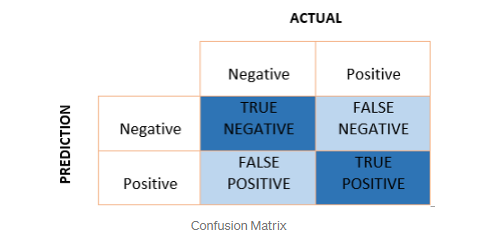

[[15  0]
 [ 2 13]]


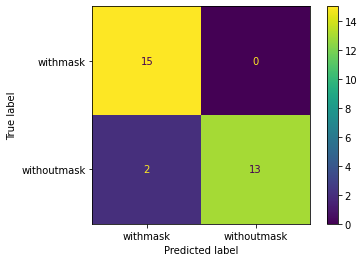

In [47]:
cm = confusion_matrix(true_categories, predicted_categories)
print(cm)
cmd = ConfusionMatrixDisplay(cm, display_labels=['withmask', 'withoutmask'])
cmd.plot()


Get the metrics  classification report  with the details as

**precision:** Out of all the positive predicted, what percentage is truly positive.

**recall:**  Out of the total positive, what percentage are predicted positive. It is the same as TPR (true positive rate).

 **F1 Score: ** It is the harmonic mean of precision and recall. It takes both false positive and false negatives into account. 

In [48]:
from sklearn import metrics
#tp, fn, fp, tn = confusion_matrix(true_categories, predicted_categories,labels=['withmask', 'withoutmask']).reshape(-1)
#print('Outcome values : \n', tp, fn, fp, tn)
print(metrics.confusion_matrix(true_categories, predicted_categories, labels=['withmask', 'withoutmask']))
print(metrics.classification_report(true_categories, predicted_categories, labels=['withmask', 'withoutmask']))

[[15  0]
 [ 2 13]]
              precision    recall  f1-score   support

    withmask       0.88      1.00      0.94        15
 withoutmask       1.00      0.87      0.93        15

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30

